In [1]:
!sshfs -o reconnect,ServerAliveInterval=120,ServerAliveCountMax=3 rennes.g5k:/srv/storage/empenn@storage2.rennes.grid5000.fr/private/ymerel /home/ymerel/storage

fusermount3: failed to access mountpoint /home/ymerel/storage: Permission denied


In [2]:
import os

datadir = os.path.join('data')
corr_path = os.path.join(datadir, 'correlations.csv')
corr_func = 'pearson'
ds_path = os.path.join(datadir, 'normalized_dataset.csv')
valid_path = os.path.join(datadir, f'valid_dataset.csv')
invalid_path = os.path.join(datadir, f'invalid_dataset.csv')
basedir = "/home/ymerel/storage/results/"
jobname = "auditory_sosym"
result_path = f"{basedir}{jobname}"

# Load data

In [3]:
import pandas as pd

dataset = dataset = pd.read_csv(ds_path, delimiter=';')
valid_df = pd.read_csv(valid_path, delimiter=';')
invalid_df = pd.read_csv(invalid_path, delimiter=';')

print(f"{len(dataset)} configs in dataset")

correlations = pd.read_csv(corr_path, delimiter=';')
print(f"{len(correlations)} correlations in matrix")

matrix = correlations.pivot(index='source', columns='target', values=corr_func).fillna(1.0)

dataset.head(1010)

1001 configs in dataset
1004004 correlations in matrix


,slice_timing_correction/ref_slice/middle,distorsion_correction,signal_modeling/temporal_noise_autocorrelation/FAST,slice_timing_correction,signal_modeling/temporal_noise_autocorrelation/AR1,spatial_normalization/algorithm/linear,motion_correction_realignment/register_to/mean,signal_modeling/hrf/temporal_derivs,spatial_normalization/algorithm/DARTEL,signal_modeling/hrf/canonical,...,spatial_normalization/bias_fwhm,spatial_smoothing/fwhm,spatial_normalization/interpolation/trilinear,spatial_normalization/template/MNI305,spatial_normalization/interpolation/bspline,id,pearson_from_ref,spearman_from_ref,pearson_from_mean,spearman_from_mean
0,False,False,True,False,False,False,True,True,False,False,...,0,6,False,False,False,d73e0359ec51c3b847656b8f2bc157b083dae2057d53a4...,0.103517,0.082454,0.263128,0.245781
1,False,False,True,True,False,False,False,False,False,True,...,0,6,True,False,False,e012bd4d9bab5a18593441c76f48ccc732bca3390703ff...,0.149047,0.124797,0.337434,0.305455
2,True,False,True,True,False,False,False,True,False,False,...,0,6,True,False,False,850e4d92a370900eede8982155772f1ba014ab468eef7c...,0.956003,0.882291,0.854730,0.697912
3,False,False,True,True,False,False,False,True,False,False,...,0,6,True,False,False,84c27a9d96a41f520b1de0bf3ef88093bcf9761b45e45e...,0.724838,0.588650,0.760644,0.584104
4,False,False,True,True,False,False,True,False,False,False,...,0,6,True,False,False,0c7beba1bec8f4ff1c5ebff7e2af248230c4ce91c27775...,0.095768,0.074215,0.272972,0.252439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,True,False,False,True,True,False,True,False,False,False,...,0,6,True,False,False,478226e8b91fd9e223848097af04e9841a0c7c8bebe003...,0.900571,0.798534,0.815145,0.667142
997,False,False,False,False,True,False,True,True,False,False,...,0,6,False,False,False,49b2e420e59aac429dbf460a5814461a2b645eb20f2387...,0.872822,0.767594,0.786408,0.635235
998,False,False,False,True,True,False,False,False,False,True,...,0,6,False,False,True,2a1e8f3ad608486da7eb9f165fa6389c641a895232a3dc...,0.657927,0.548311,0.758439,0.600097
999,True,False,True,True,False,False,True,False,False,True,...,0,6,False,False,False,cd5f0844e445d6ab574976706eb2929d22072940c7433e...,0.562473,0.446034,0.774017,0.610582


# Declare cluster prediction method

In [4]:
from utils import get_cluster_silhouette
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz, DecisionTreeClassifier
import numpy as np

@ignore_warnings(category=UserWarning)
def predict_clusters(dataset, correlations, nb_clusters, threshold, test_prop=0.1):
    
    ignored = [col for col in dataset.columns if col.endswith('from_ref')]
    ignored.extend([col for col in dataset.columns if col.endswith('from_mean')])
    ignored.extend(['id', 'cluster'])
    
    train_ds, test_ds = train_test_split(dataset, test_size=test_prop, random_state=None)
    
    test_ds_clustered, matrix, _, _ = clusterize_hierch(test_ds, correlations, test_ds['id'], nb_clusters, corr_func, threshold)
    
    test_ds_clustered = test_ds_clustered.sample(frac=1, random_state=None).reset_index(drop=True)
    y_test = test_ds_clustered['cluster']
    X_test = test_ds_clustered.drop(columns=ignored).copy()

    results_list = []
    
    proportions = np.round(np.arange(0.2, 1.1, 0.1), decimals=1)
    for prop in proportions:
        
        train_size = int(prop * (len(train_ds)))
    
        results = {
            'train_size': train_size,
            'f1_score': 0.0,
            'feature_importance': {},
            'decision_tree': None,  # Only store the last tree
            'nb_features': 0.0,
            'nb_clusters': 0.0,
            'silhouette_score': -1
        }
    
        # Split into train and test sets
        if prop == 1.0:
            sub_train_ds = train_ds.copy()
        else:
            sub_train_ds, _ = train_test_split(train_ds, train_size=train_size, random_state=None)
        
        sub_train_ds_clustered, matrix, _, clusters = clusterize_hierch(sub_train_ds, correlations, sub_train_ds['id'], nb_clusters, corr_func, threshold)
        sub_train_ds_clustered = sub_train_ds_clustered.sample(frac=1, random_state=None).reset_index(drop=True)
        y_train = sub_train_ds_clustered['cluster']
        results['nb_clusters'] = y_train.nunique()
        X_train = sub_train_ds_clustered.drop(columns=ignored).copy()
        
        results['silhouette_score'] = get_cluster_silhouette(matrix.values, clusters.values)
    
        # Train the classifier
        classifier = DecisionTreeClassifier(random_state=None)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
    
        # Classification report
        all_classes = sorted(set(y_test.unique()).union(set(np.unique(y_pred))))
        target_names = [str(name) for name in all_classes]
        report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True, zero_division=0)
        results['f1_score'] = report['macro avg']['f1-score']
        results['recall'] = report['macro avg']['recall']
        results['precision'] = report['macro avg']['precision']
    
        # Feature importances
        features = X_train.columns
        importances = classifier.feature_importances_
        results['feature_importance'] = {feat: imp for feat, imp in zip(features, importances) if imp > 0.0}
        results['nb_features'] = len(results['feature_importance'])
    
        results['decision_tree'] = export_graphviz(
            classifier,
            out_file=None,
            feature_names=X_train.columns.values,
            filled=True,
            rounded=True,
            special_characters=True,
            leaves_parallel=True,
            proportion=True
        )
    
        results_list.append(results)

    return pd.DataFrame(results_list)

## [Full] Cluster by 4 - Predict over 100 iterations

In [5]:
import graphviz
from utils import clusterize_hierch

nb_iter = 100

all_results = []
for i in range(1, nb_iter+1):    
    results_df = predict_clusters(dataset, correlations,4, None, 0.3)
    results_df['iteration'] = i
    all_results.append(results_df)
    
classifier_full_results = pd.concat(all_results, ignore_index=True)

# print graph
max_train_size = classifier_full_results.loc[classifier_full_results['iteration'] == nb_iter, 'train_size'].max()
decision_tree = classifier_full_results.loc[
    (classifier_full_results['train_size'] == max_train_size) &
    (classifier_full_results['iteration'] == nb_iter),
    'decision_tree'
].iloc[0]
graph = graphviz.Source(decision_tree)
graph.render(f"full_4_clusters", format='svg')
classifier_full_results.head(100)

,train_size,f1_score,feature_importance,decision_tree,nb_features,nb_clusters,silhouette_score,recall,precision,iteration
0,140,0.916582,{'signal_modeling/hrf/temporal_derivs': 0.0103...,"digraph Tree {\nnode [shape=box, style=""filled...",9,4,0.432042,0.922414,0.934783,1
1,210,1.000000,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",4,4,0.472891,1.000000,1.000000,1
2,280,1.000000,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",4,4,0.449958,1.000000,1.000000,1
3,350,0.500000,{'coregistration/source_target/func_on_anat': ...,"digraph Tree {\nnode [shape=box, style=""filled...",4,4,0.462614,0.500000,0.500000,1
4,420,0.500000,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",4,4,0.464006,0.500000,0.500000,1
...,...,...,...,...,...,...,...,...,...,...
95,489,0.796704,{'signal_modeling/nuisance_regressors': 0.0274...,"digraph Tree {\nnode [shape=box, style=""filled...",6,4,0.342213,0.797736,0.799435,11
96,560,0.751319,{'coregistration/cost_function/normalised_cros...,"digraph Tree {\nnode [shape=box, style=""filled...",4,4,0.362148,0.766720,0.773175,11
97,630,0.796704,{'coregistration/source_target/func_on_anat': ...,"digraph Tree {\nnode [shape=box, style=""filled...",5,4,0.326800,0.797736,0.799435,11
98,700,0.796704,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",5,4,0.332936,0.797736,0.799435,11


# Plot prediction results (full dataset)

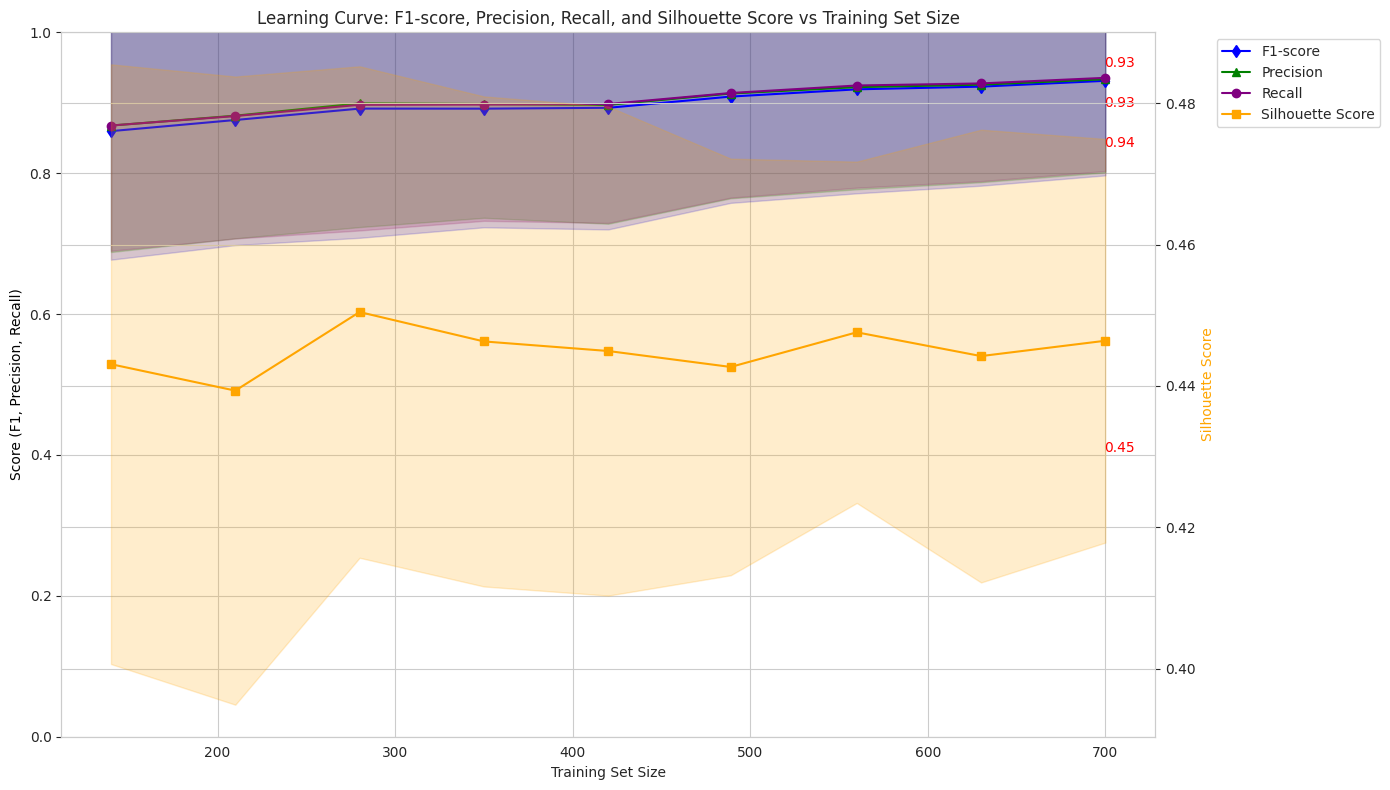

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Group by train_size and calculate mean and std for all metrics
grouped_f1 = classifier_full_results.groupby('train_size')['f1_score'].agg(['mean', 'std']).reset_index()
grouped_precision = classifier_full_results.groupby('train_size')['precision'].agg(['mean', 'std']).reset_index()
grouped_recall = classifier_full_results.groupby('train_size')['recall'].agg(['mean', 'std']).reset_index()
grouped_features = classifier_full_results.groupby('train_size')['silhouette_score'].agg(['mean', 'std']).reset_index()

# Use the unique train_size values from the grouped data for the x-axis
train_sizes = grouped_f1['train_size'].unique()

# Plotting
plt.figure(figsize=(14, 8))

# Primary axis for F1-score, Precision, and Recall
ax1 = plt.gca()
ax1.set_xlabel('Training Set Size')
ax1.set_ylabel('Score (F1, Precision, Recall)', color='black')
ax1.set_ylim(0, 1)

# Plot F1-score
ax1.plot(
    train_sizes,
    grouped_f1['mean'],
    marker='d',
    label='F1-score',
    color='blue'
)
ax1.fill_between(
    train_sizes,
    grouped_f1['mean'] - grouped_f1['std'],
    grouped_f1['mean'] + grouped_f1['std'],
    alpha=0.2,
    color='blue'
)

# Plot Precision
ax1.plot(
    train_sizes,
    grouped_precision['mean'],
    marker='^',
    label='Precision',
    color='green'
)
ax1.fill_between(
    train_sizes,
    grouped_precision['mean'] - grouped_precision['std'],
    grouped_precision['mean'] + grouped_precision['std'],
    alpha=0.2,
    color='green'
)

# Plot Recall
ax1.plot(
    train_sizes,
    grouped_recall['mean'],
    marker='o',
    label='Recall',
    color='purple'
)
ax1.fill_between(
    train_sizes,
    grouped_recall['mean'] - grouped_recall['std'],
    grouped_recall['mean'] + grouped_recall['std'],
    alpha=0.2,
    color='purple'
)

# Annotate the last values
ax1.annotate(
    f'{grouped_f1["mean"].iloc[-1]:.2f}',
    (train_sizes[-1], grouped_f1["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=10,
    color='red'
)

ax1.annotate(
    f'{grouped_precision["mean"].iloc[-1]:.2f}',
    (train_sizes[-1], grouped_precision["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, -20),
    ha='center',
    fontsize=10,
    color='red'
)

ax1.annotate(
    f'{grouped_recall["mean"].iloc[-1]:.2f}',
    (train_sizes[-1], grouped_recall["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, -50),
    ha='center',
    fontsize=10,
    color='red'
)

# Secondary axis for Silhouette Score
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='orange')
ax2.plot(
    train_sizes,
    grouped_features['mean'],
    marker='s',
    label='Silhouette Score',
    color='orange'
)
ax2.fill_between(
    train_sizes,
    grouped_features['mean'] - grouped_features['std'],
    grouped_features['mean'] + grouped_features['std'],
    alpha=0.2,
    color='orange'
)

# Annotate the last value of Silhouette Score
ax2.annotate(
    f'{grouped_features["mean"].iloc[-1]:.2f}',
    (train_sizes[-1], grouped_features["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, -80),
    ha='center',
    fontsize=10,
    color='red'
)

# Place the legend outside the figure
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Learning Curve: F1-score, Precision, Recall, and Silhouette Score vs Training Set Size')
plt.grid(True)
plt.tight_layout()
plt.show()


## [Valid] Cluster by 4 - Predict over 100 iterations

In [7]:
import graphviz
from utils import clusterize_hierch

all_results = []
for i in range(1, nb_iter+1):
        
    results_df = predict_clusters(valid_df, correlations, 4, None, 0.1)
    results_df['iteration'] = i
    all_results.append(results_df)
    
classifier_valid_results = pd.concat(all_results, ignore_index=True)

# print graph
max_train_size = classifier_valid_results.loc[classifier_valid_results['iteration'] == nb_iter, 'train_size'].max()
decision_tree = classifier_valid_results.loc[
    (classifier_valid_results['train_size'] == max_train_size) &
    (classifier_valid_results['iteration'] == nb_iter),
    'decision_tree'
].iloc[0]
graph = graphviz.Source(decision_tree)
graph.render(f"valid_4_clusters", format='svg')
classifier_valid_results.head(100)

,train_size,f1_score,feature_importance,decision_tree,nb_features,nb_clusters,silhouette_score,recall,precision,iteration
0,133,0.372222,{'signal_modeling/nuisance_regressors': 0.0713...,"digraph Tree {\nnode [shape=box, style=""filled...",4,4,0.443003,0.411765,0.348214,1
1,200,0.500000,{'signal_modeling/nuisance_regressors': 0.0518...,"digraph Tree {\nnode [shape=box, style=""filled...",7,4,0.387816,0.500000,0.500000,1
2,267,0.940351,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",4,4,0.398083,0.941176,0.952381,1
3,334,0.940351,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",3,4,0.418262,0.941176,0.952381,1
4,401,0.955536,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",3,4,0.392132,0.955882,0.962500,1
...,...,...,...,...,...,...,...,...,...,...
95,468,0.284970,{'signal_modeling/nuisance_regressors': 0.0468...,"digraph Tree {\nnode [shape=box, style=""filled...",6,4,0.402339,0.266746,0.307692,11
96,535,0.458683,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",3,4,0.392354,0.424641,0.500000,11
97,602,0.270353,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",5,4,0.410027,0.253589,0.291667,11
98,669,0.458683,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",3,4,0.397159,0.424641,0.500000,11


# Plot prediction results (valid dataset)

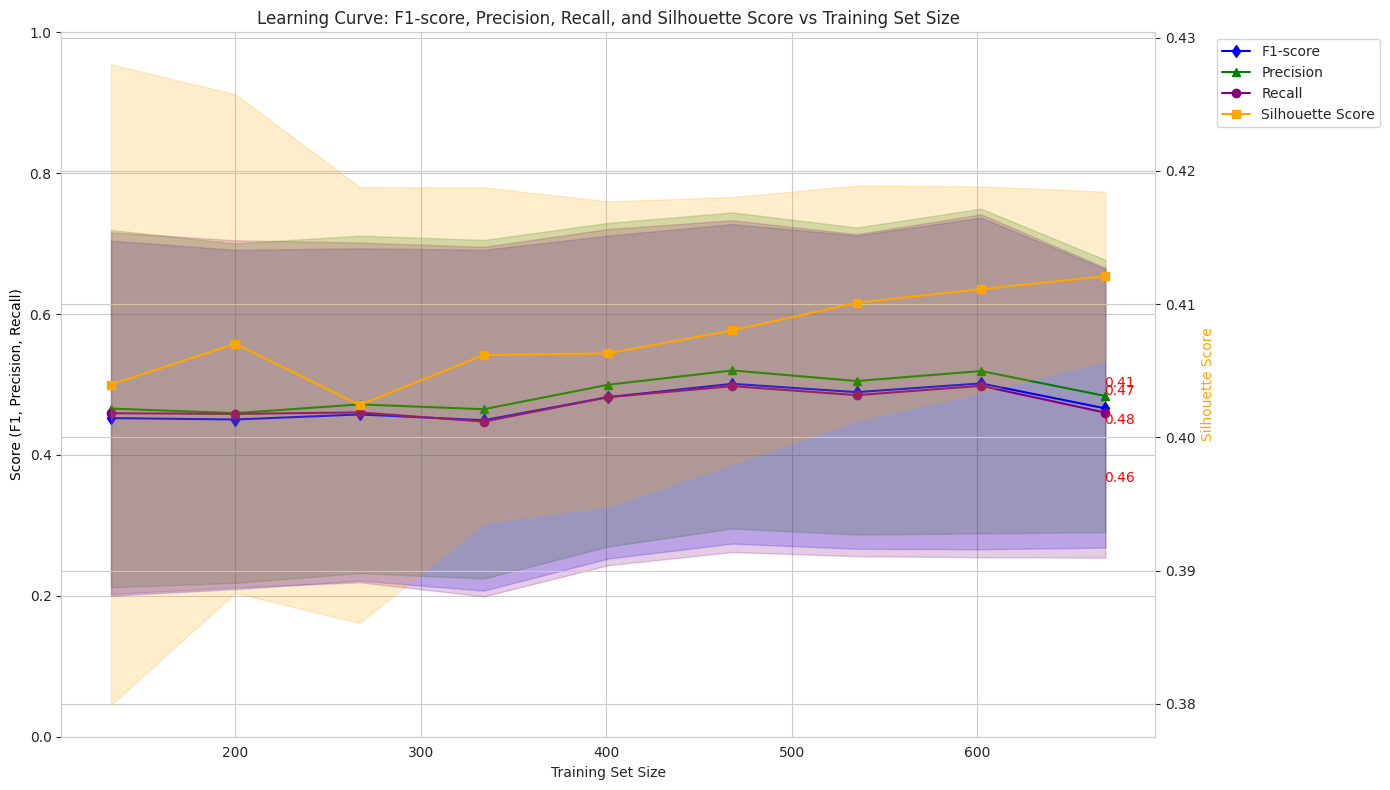

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Group by train_size and calculate mean and std for all metrics
grouped_f1 = classifier_valid_results.groupby('train_size')['f1_score'].agg(['mean', 'std']).reset_index()
grouped_precision = classifier_valid_results.groupby('train_size')['precision'].agg(['mean', 'std']).reset_index()
grouped_recall = classifier_valid_results.groupby('train_size')['recall'].agg(['mean', 'std']).reset_index()
grouped_features = classifier_valid_results.groupby('train_size')['silhouette_score'].agg(['mean', 'std']).reset_index()

# Use the unique train_size values from the grouped data for the x-axis
train_sizes = grouped_f1['train_size'].unique()

# Plotting
plt.figure(figsize=(14, 8))

# Primary axis for F1-score, Precision, and Recall
ax1 = plt.gca()
ax1.set_xlabel('Training Set Size')
ax1.set_ylabel('Score (F1, Precision, Recall)', color='black')
ax1.set_ylim(0, 1)

# Plot F1-score
ax1.plot(
    train_sizes,
    grouped_f1['mean'],
    marker='d',
    label='F1-score',
    color='blue'
)
ax1.fill_between(
    train_sizes,
    grouped_f1['mean'] - grouped_f1['std'],
    grouped_f1['mean'] + grouped_f1['std'],
    alpha=0.2,
    color='blue'
)

# Plot Precision
ax1.plot(
    train_sizes,
    grouped_precision['mean'],
    marker='^',
    label='Precision',
    color='green'
)
ax1.fill_between(
    train_sizes,
    grouped_precision['mean'] - grouped_precision['std'],
    grouped_precision['mean'] + grouped_precision['std'],
    alpha=0.2,
    color='green'
)

# Plot Recall
ax1.plot(
    train_sizes,
    grouped_recall['mean'],
    marker='o',
    label='Recall',
    color='purple'
)
ax1.fill_between(
    train_sizes,
    grouped_recall['mean'] - grouped_recall['std'],
    grouped_recall['mean'] + grouped_recall['std'],
    alpha=0.2,
    color='purple'
)

# Annotate the last values
ax1.annotate(
    f'{grouped_f1["mean"].iloc[-1]:.2f}',
    (train_sizes[-1], grouped_f1["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=10,
    color='red'
)

ax1.annotate(
    f'{grouped_precision["mean"].iloc[-1]:.2f}',
    (train_sizes[-1], grouped_precision["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, -20),
    ha='center',
    fontsize=10,
    color='red'
)

ax1.annotate(
    f'{grouped_recall["mean"].iloc[-1]:.2f}',
    (train_sizes[-1], grouped_recall["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, -50),
    ha='center',
    fontsize=10,
    color='red'
)

# Secondary axis for Silhouette Score
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='orange')
ax2.plot(
    train_sizes,
    grouped_features['mean'],
    marker='s',
    label='Silhouette Score',
    color='orange'
)
ax2.fill_between(
    train_sizes,
    grouped_features['mean'] - grouped_features['std'],
    grouped_features['mean'] + grouped_features['std'],
    alpha=0.2,
    color='orange'
)

# Annotate the last value of Silhouette Score
ax2.annotate(
    f'{grouped_features["mean"].iloc[-1]:.2f}',
    (train_sizes[-1], grouped_features["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, -80),
    ha='center',
    fontsize=10,
    color='red'
)

# Place the legend outside the figure
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Learning Curve: F1-score, Precision, Recall, and Silhouette Score vs Training Set Size')
plt.grid(True)
plt.tight_layout()
plt.show()


## [Valid] Cluster by threshold - Predict over 10 iterations

In [9]:
from utils import clusterize_hierch
import numpy as np
from concurrent.futures import ProcessPoolExecutor

@ignore_warnings(category=UserWarning)
def run_iteration(ds, correlations, threshold, iteration):
        
    results_df = predict_clusters(ds, correlations, None, threshold, 0.3)
    results_df['threshold'] = threshold
    results_df['iteration'] = iteration
    return results_df

all_results = []
print(len(valid_df))

# Thresholds from 0.10 to 0.001 with a step of -0.001
thresholds = np.round(np.arange(0.30, 0.01 - 0.01, -0.01), decimals=2)

for threshold in thresholds:
    print(f'Clustering threshold : {threshold}')
    
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(run_iteration, valid_df, correlations, threshold, i) for i in range(1, 11)]
        results = [future.result() for future in futures]
    all_results.extend(results)
all_results_df = pd.concat(all_results, ignore_index=True)

744
Clustering threshold : 0.3
Clustering threshold : 0.29
Clustering threshold : 0.28
Clustering threshold : 0.27
Clustering threshold : 0.26
Clustering threshold : 0.25
Clustering threshold : 0.24
Clustering threshold : 0.23
Clustering threshold : 0.22
Clustering threshold : 0.21
Clustering threshold : 0.2
Clustering threshold : 0.19
Clustering threshold : 0.18
Clustering threshold : 0.17
Clustering threshold : 0.16
Clustering threshold : 0.15
Clustering threshold : 0.14
Clustering threshold : 0.13
Clustering threshold : 0.12
Clustering threshold : 0.11
Clustering threshold : 0.1
Clustering threshold : 0.09
Clustering threshold : 0.08
Clustering threshold : 0.07
Clustering threshold : 0.06
Clustering threshold : 0.05
Clustering threshold : 0.04
Clustering threshold : 0.03
Clustering threshold : 0.02
Clustering threshold : 0.01


In [10]:
all_results_df.head(100)

,train_size,f1_score,feature_importance,decision_tree,nb_features,nb_clusters,silhouette_score,recall,precision,threshold,iteration
0,104,0.818167,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",3,2,0.344847,0.82906,0.863946,0.30,1
1,156,1.000000,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",2,2,0.356484,1.00000,1.000000,0.30,1
2,208,0.000000,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",2,2,0.409778,0.00000,0.000000,0.30,1
3,260,1.000000,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",2,2,0.396589,1.00000,1.000000,0.30,1
4,312,1.000000,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",2,2,0.397003,1.00000,1.000000,0.30,1
...,...,...,...,...,...,...,...,...,...,...,...
95,364,1.000000,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",2,2,0.388943,1.00000,1.000000,0.29,1
96,416,1.000000,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",2,2,0.407566,1.00000,1.000000,0.29,1
97,468,1.000000,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",2,2,0.396845,1.00000,1.000000,0.29,1
98,520,1.000000,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",2,2,0.398887,1.00000,1.000000,0.29,1


# Plot prediction results (valid dataset)

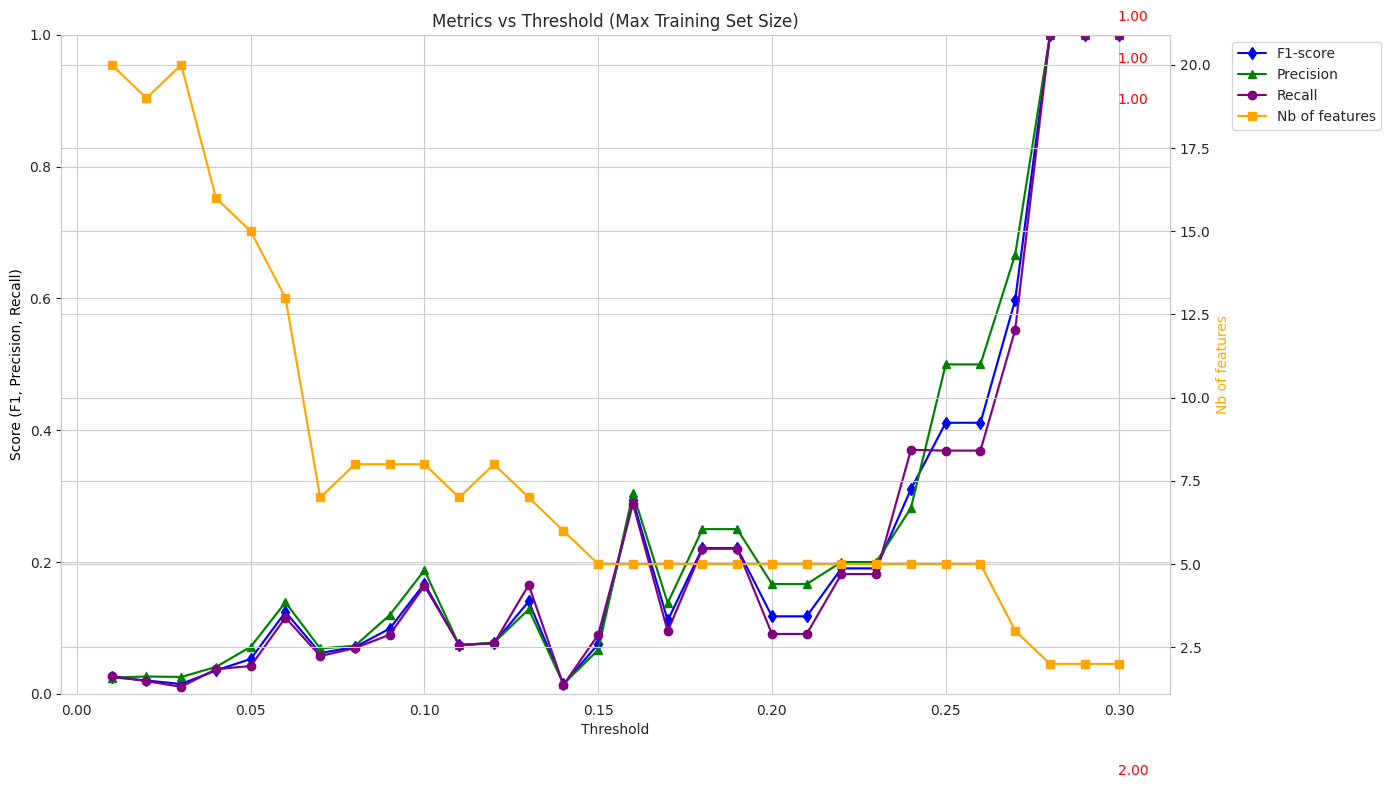

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Filter the DataFrame to include only rows with the maximum train_size
max_train_size = all_results_df['train_size'].max()
filtered_results = all_results_df[all_results_df['train_size'] == max_train_size]

# Group by threshold and calculate mean and std for all metrics
grouped_f1 = filtered_results.groupby('threshold')['f1_score'].agg(['mean', 'std']).reset_index()
grouped_precision = filtered_results.groupby('threshold')['precision'].agg(['mean', 'std']).reset_index()
grouped_recall = filtered_results.groupby('threshold')['recall'].agg(['mean', 'std']).reset_index()
grouped_features = filtered_results.groupby('threshold')['nb_features'].agg(['mean', 'std']).reset_index()

# Use the unique threshold values from the grouped data for the x-axis
thresholds = grouped_f1['threshold'].unique()

# Plotting
plt.figure(figsize=(14, 8))

# Primary axis for F1-score, Precision, and Recall
ax1 = plt.gca()
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score (F1, Precision, Recall)', color='black')
ax1.set_ylim(0, 1)

# Plot F1-score
ax1.plot(
    thresholds,
    grouped_f1['mean'],
    marker='d',
    label='F1-score',
    color='blue'
)
ax1.fill_between(
    thresholds,
    grouped_f1['mean'] - grouped_f1['std'],
    grouped_f1['mean'] + grouped_f1['std'],
    alpha=0.2,
    color='blue'
)

# Plot Precision
ax1.plot(
    thresholds,
    grouped_precision['mean'],
    marker='^',
    label='Precision',
    color='green'
)
ax1.fill_between(
    thresholds,
    grouped_precision['mean'] - grouped_precision['std'],
    grouped_precision['mean'] + grouped_precision['std'],
    alpha=0.2,
    color='green'
)

# Plot Recall
ax1.plot(
    thresholds,
    grouped_recall['mean'],
    marker='o',
    label='Recall',
    color='purple'
)
ax1.fill_between(
    thresholds,
    grouped_recall['mean'] - grouped_recall['std'],
    grouped_recall['mean'] + grouped_recall['std'],
    alpha=0.2,
    color='purple'
)

# Annotate the last values
ax1.annotate(
    f'{grouped_f1["mean"].iloc[-1]:.2f}',
    (thresholds[-1], grouped_f1["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=10,
    color='red'
)

ax1.annotate(
    f'{grouped_precision["mean"].iloc[-1]:.2f}',
    (thresholds[-1], grouped_precision["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, -20),
    ha='center',
    fontsize=10,
    color='red'
)

ax1.annotate(
    f'{grouped_recall["mean"].iloc[-1]:.2f}',
    (thresholds[-1], grouped_recall["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, -50),
    ha='center',
    fontsize=10,
    color='red'
)

# Secondary axis for Silhouette Score
ax2 = ax1.twinx()
ax2.set_ylabel('Nb of features', color='orange')

ax2.plot(
    thresholds,
    grouped_features['mean'],
    marker='s',
    label='Nb of features',
    color='orange'
)
ax2.fill_between(
    thresholds,
    grouped_features['mean'] - grouped_features['std'],
    grouped_features['mean'] + grouped_features['std'],
    alpha=0.2,
    color='orange'
)

# Annotate the last value of Silhouette Score
ax2.annotate(
    f'{grouped_features["mean"].iloc[-1]:.2f}',
    (thresholds[-1], grouped_features["mean"].iloc[-1]),
    textcoords="offset points",
    xytext=(10, -80),
    ha='center',
    fontsize=10,
    color='red'
)

# Place the legend outside the figure
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Metrics vs Threshold (Max Training Set Size)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd

# Assuming all_results_df is your DataFrame with columns: threshold, iteration, train_size, f1_score

# Step 1: For each threshold and iteration, keep only rows where train_size is max
max_train_size_rows = all_results_df[
    all_results_df.groupby(['threshold', 'iteration'])['train_size'].transform('max') == all_results_df['train_size']
]

# Step 2: Calculate the mean f1_score for each threshold (over all iterations and max train_size)
mean_f1_per_threshold = max_train_size_rows.groupby('threshold')['f1_score'].mean().reset_index()

# Step 3: Filter thresholds where mean f1_score > 0.9
valid_thresholds = mean_f1_per_threshold[mean_f1_per_threshold['f1_score'] > 0.1]['threshold']

# Step 4: Keep only rows in max_train_size_rows where threshold is in valid_thresholds
filtered_df = max_train_size_rows[max_train_size_rows['threshold'].isin(valid_thresholds)]

# Result
filtered_df.head(1000)

,train_size,f1_score,feature_importance,decision_tree,nb_features,nb_clusters,silhouette_score,recall,precision,threshold,iteration
8,520,1.000000,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",2,2,0.398887,1.000000,1.000000,0.30,1
17,520,1.000000,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",2,2,0.398887,1.000000,1.000000,0.30,2
26,520,1.000000,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",2,2,0.398887,1.000000,1.000000,0.30,3
35,520,1.000000,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",2,2,0.398887,1.000000,1.000000,0.30,4
44,520,1.000000,{'signal_modeling/hrf/temporal_dispersion_deri...,"digraph Tree {\nnode [shape=box, style=""filled...",2,2,0.398887,1.000000,1.000000,0.30,5
...,...,...,...,...,...,...,...,...,...,...,...
2213,520,0.124074,{'slice_timing_correction': 0.0223381226980291...,"digraph Tree {\nnode [shape=box, style=""filled...",13,37,0.569948,0.115741,0.138889,0.06,6
2222,520,0.124074,{'slice_timing_correction': 0.0223381226980291...,"digraph Tree {\nnode [shape=box, style=""filled...",13,37,0.569948,0.115741,0.138889,0.06,7
2231,520,0.124074,{'slice_timing_correction': 0.0223381226980291...,"digraph Tree {\nnode [shape=box, style=""filled...",13,37,0.569948,0.115741,0.138889,0.06,8
2240,520,0.124074,{'slice_timing_correction': 0.0223381226980291...,"digraph Tree {\nnode [shape=box, style=""filled...",13,37,0.569948,0.115741,0.138889,0.06,9
